<a href="https://colab.research.google.com/github/BobLiuGZ/time-series-analysis/blob/master/Test(LB%5B1%2C20%5D)_of_Out_LSTM_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6637622517362007546
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9235944999185297142
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3835738554058263706
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14209977549
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16282262312938676937
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


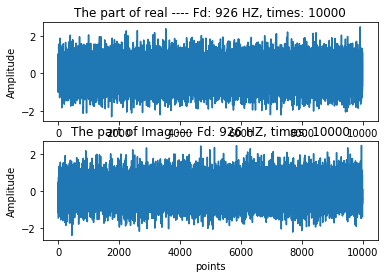

(10000, 1)


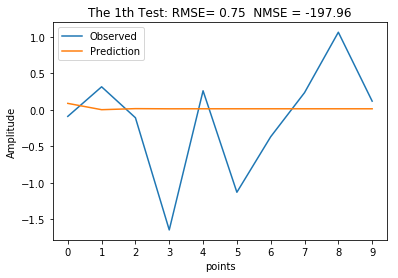

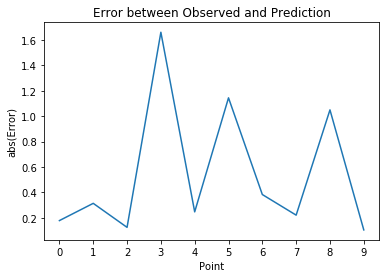

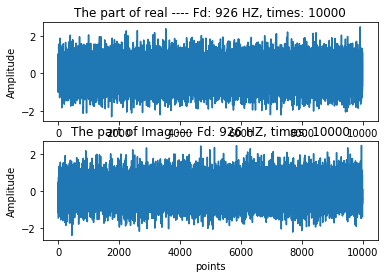

(10000, 1)


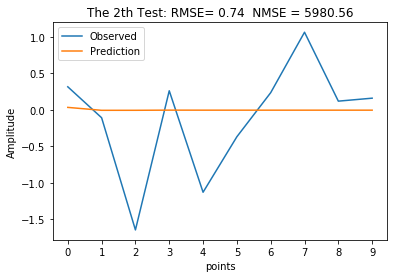

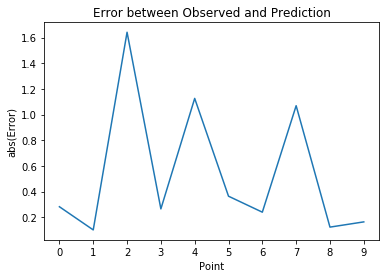

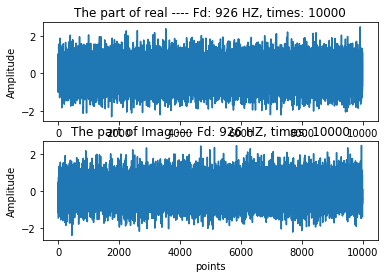

(10000, 1)


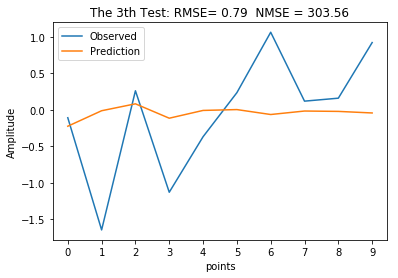

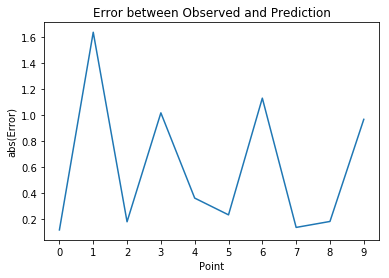

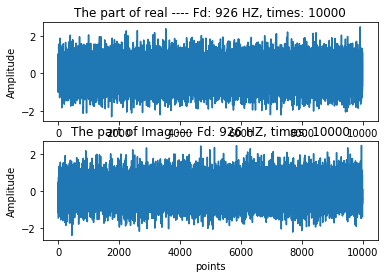

(10000, 1)


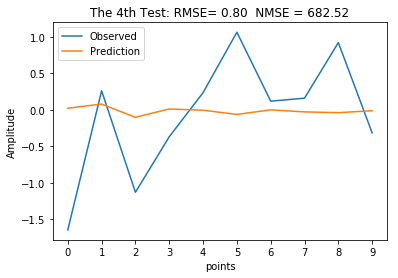

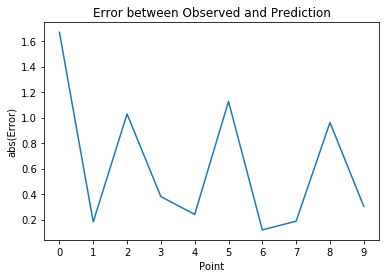

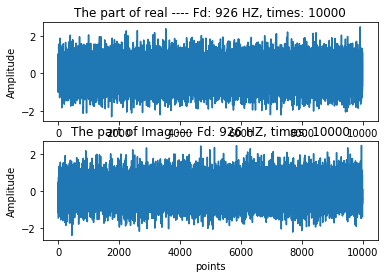

(10000, 1)


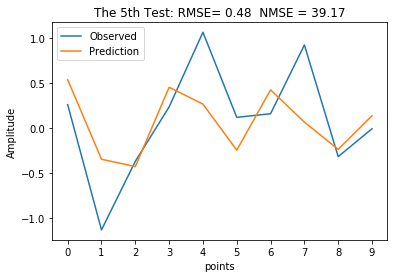

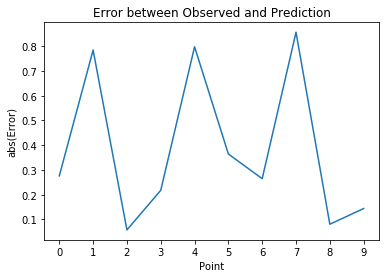

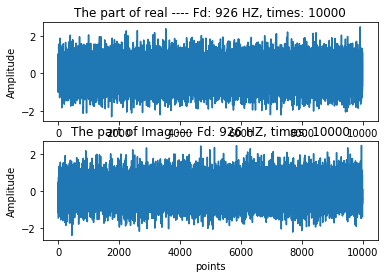

(10000, 1)


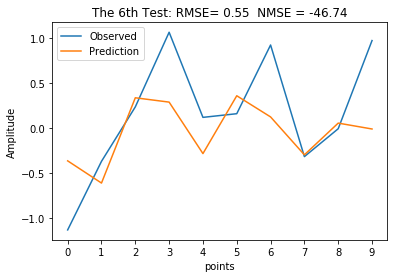

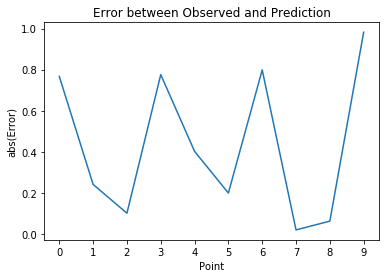

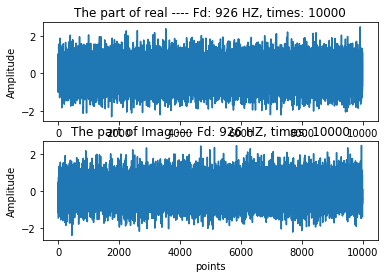

(10000, 1)


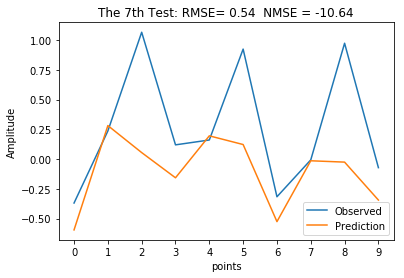

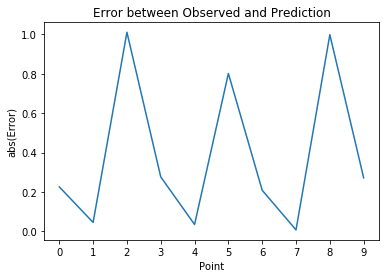

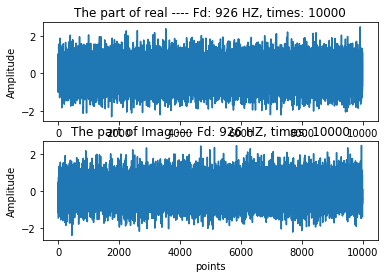

(10000, 1)


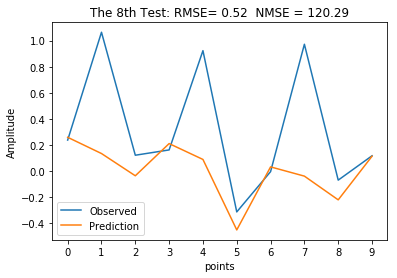

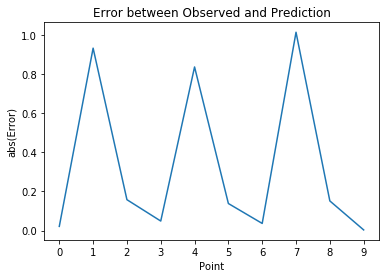

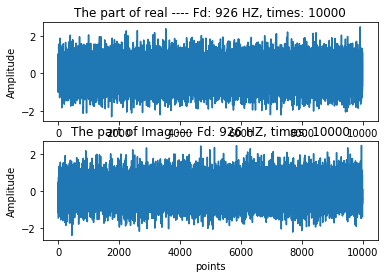

(10000, 1)


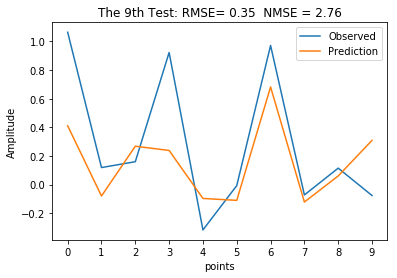

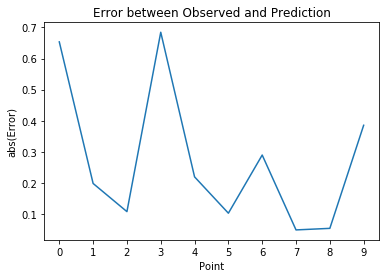

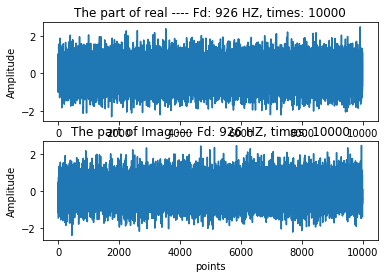

(10000, 1)


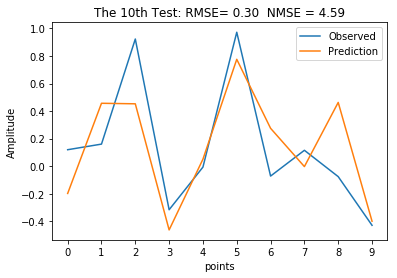

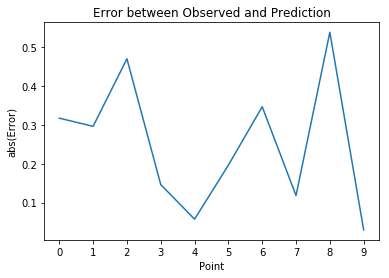

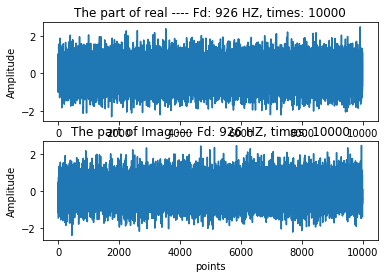

(10000, 1)


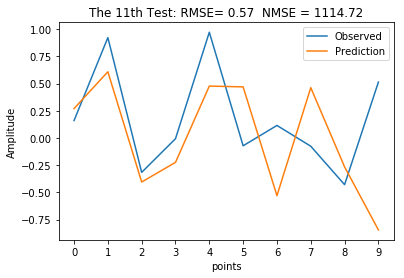

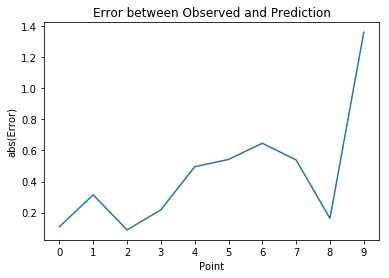

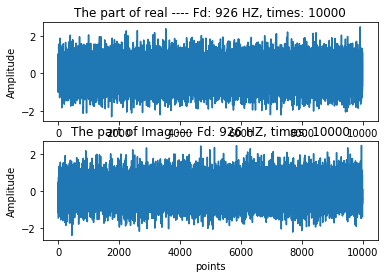

(10000, 1)


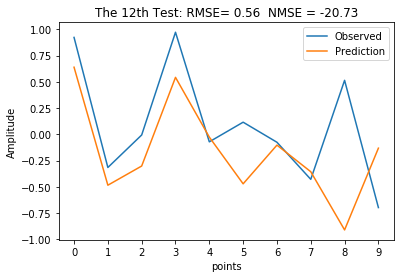

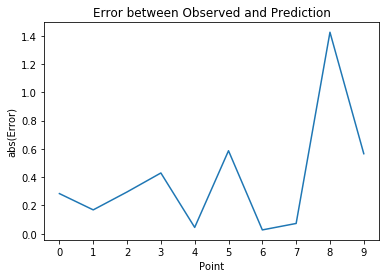

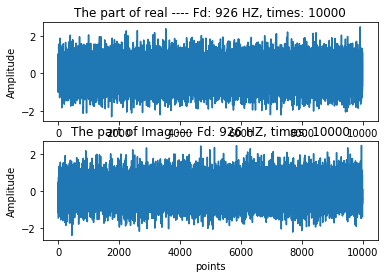

(10000, 1)


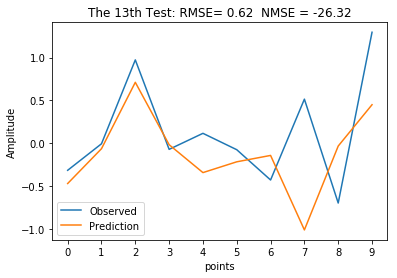

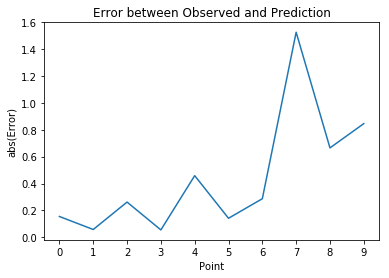

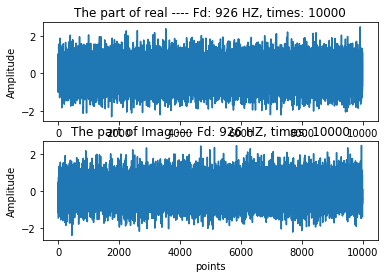

(10000, 1)


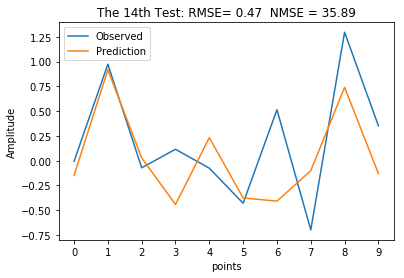

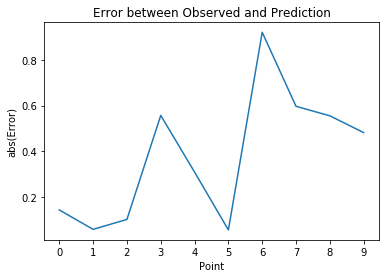

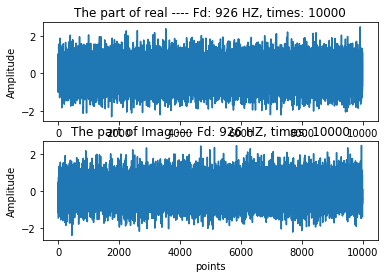

(10000, 1)


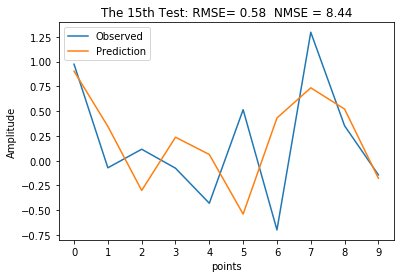

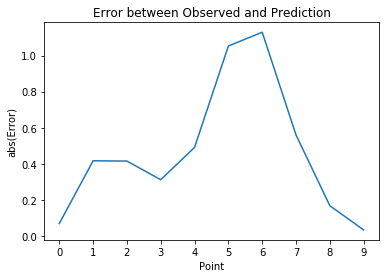

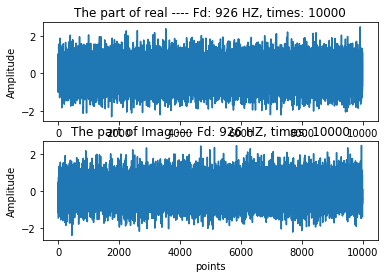

(10000, 1)


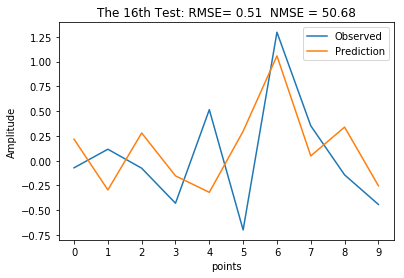

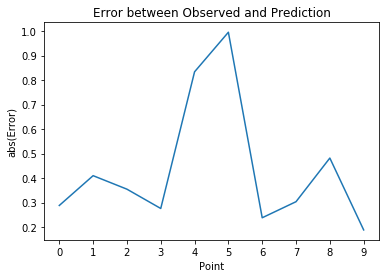

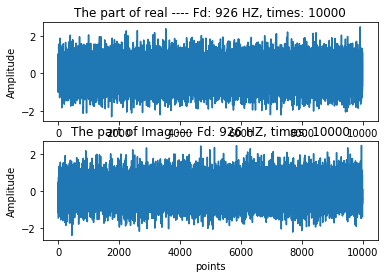

(10000, 1)


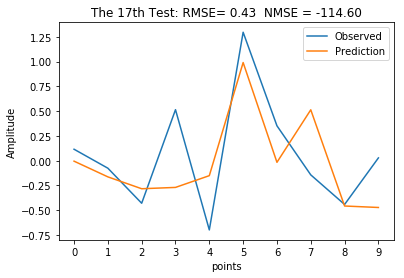

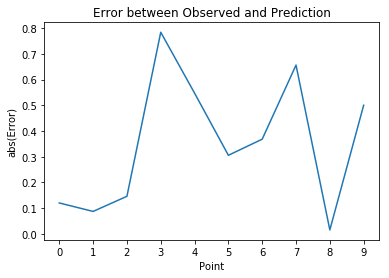

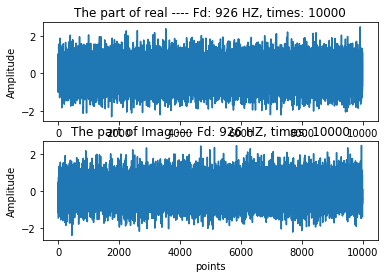

(10000, 1)


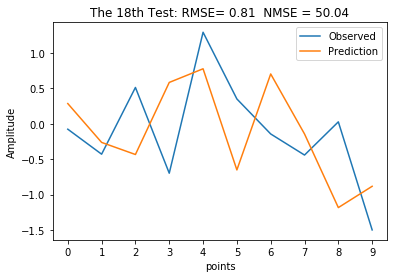

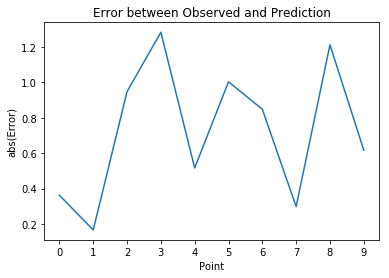

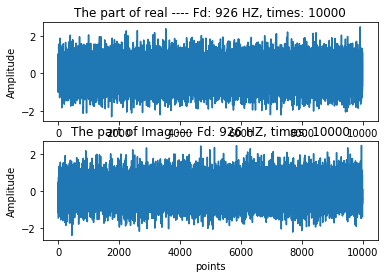

(10000, 1)


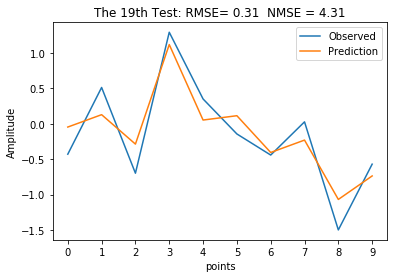

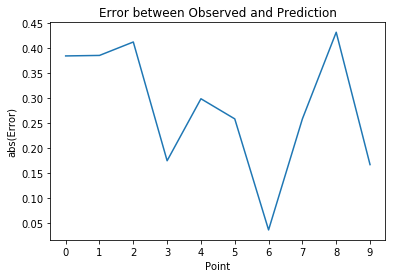

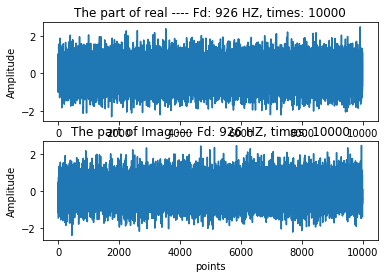

(10000, 1)


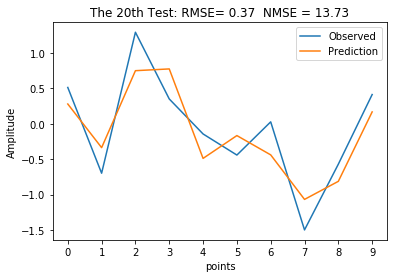

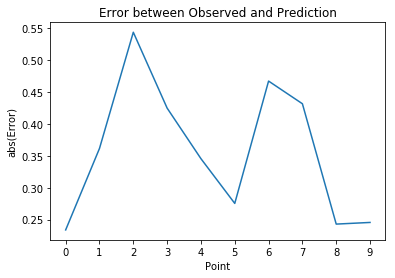

In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, LSTM, CuDNNLSTM
from tensorflow.keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# In[3]:


import os
from tensorflow.python.client import device_lib

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "99"

if __name__ == "__main__":
    print(device_lib.list_local_devices())

# In[4]:


config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)


# In[5]:
# The Generation of Multiple Uncorrelated Rayleigh Fading Waveforms
def Rayleigh(fd, time):
    '''
    改进的jakes模型来产生单径的平坦型瑞利衰落信道
    :param Fd: 信道的最大多普勒频移 单位Hz
    :param T: 信号的抽样时间序列，抽样间隔单位s
    :return data: 为输出的瑞利信道函数，是一个时间函数复序列

    '''
    np.random.seed(2019)
    t = []
    alfa = []
    for i in range(1, time + 1):
        t.append(i)

    length = len(t)
    # 假设的入射波数目
    n = 40
    # 每象限的入射波数目即振荡器数目
    n0 = n // 4

    wm = 2 * math.pi * fd
    # 信道函数的实部
    tc = np.zeros((1, length))
    # 信道函数的虚部
    ts = np.zeros((1, length))
    # 归一化功率系数
    p_nor = math.sqrt(1 / n0)
    # 区别个条路径的均匀分布随机相位
    theta = 2 * math.pi * np.random.rand(1, 1) - math.pi
    for ii in range(1, n0 + 1):
        # 第i条入射波的入射角
        alfa.append((2 * math.pi * ii - math.pi + theta) / n)
        # 对每个子载波而言在(-pi,pi)之间均匀分布的随机相位
        fi_tc = 2 * math.pi + np.random.rand(1, 1) - math.pi
        fi_ts = 2 * math.pi + np.random.rand(1, 1) - math.pi
        # 计算冲激响应函数
        tc = tc + np.cos(math.cos(alfa[ii - 1]) * wm * np.array(t) + fi_tc)
        ts = ts + np.cos(math.sin(alfa[ii - 1]) * wm * np.array(t) + fi_ts)

    # 乘归一化功率系数得到传输函数
    ray_data = p_nor * (tc + 1j * ts)

    return ray_data

for i in range(20):
  # The plot of Real and Image part of Raleigh Fading Channel
  fd = 926
  t = 10000
  data = Rayleigh(fd, t)
  # print(Rdata.tpye)
  real = data.real
  imag = data.imag
  plt.subplot(211)
  plt.plot(real[0])
  plt.xlabel('points')
  plt.ylabel('Amplitude')
  plt.title('The part of real ---- Fd: ' + str(fd) + ' HZ, times: ' + str(t))
  plt.subplot(212)
  plt.plot(imag[0])
  plt.xlabel('points')
  plt.ylabel('Amplitude')
  plt.title('The part of Imag ---- Fd: ' + str(fd) + ' HZ, times: ' + str(t))
  plt.show()

  # In[6]:

  Rdata = real[0].reshape(-1, 1)
  print(np.shape(Rdata))
  scaler = MinMaxScaler(feature_range=(0, 1))
  Rdata = scaler.fit_transform(Rdata)

  # In[7]:


  # split into training and test
  train_size = int(len(Rdata) * 0.9)
  test_size = len(Rdata) - train_size
  # predict_size = len(Rdata) - train_size
  train, test = Rdata[0:train_size, :], Rdata[train_size:len(Rdata), :]


  # In[8]:


  # convert data into training dataset and Label dataset
  def create_dataset(dataset, look_back):
      dataX, dataY = [], []
      for i in range(len(dataset) - look_back):
          a = dataset[i:(i + look_back), 0]
          dataX.append(a)
          dataY.append(dataset[i + look_back, 0])
      return np.array(dataX), np.array(dataY)


  # In[9]:


  look_back = i+1
  trainX, trainY = create_dataset(train, look_back)
  testX, testY = create_dataset(test, look_back)
  trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
  testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))


  # training the model
  def model_building():
      model = Sequential()
      model.add(CuDNNLSTM(100))
      model.add(Dense(1, activation='sigmoid'))
      model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_squared_error"])
      return model


  model = model_building()
  model.fit(trainX, trainY, epochs=100, validation_split=0.2, batch_size=512, verbose=0)


  # In[35]:


  def moving_test_window_preds(n_future_preds):
      preds_moving = []  # Use this to store the prediction made on each test window
      moving_test_window = [testX[0, :].tolist()]  # Creating the first test window
      moving_test_window = np.array(moving_test_window)  # Making it an numpy array

      for i in range(n_future_preds):
          preds_one_step = model.predict(
              moving_test_window)  # Note that this is already a scaled prediction so no need to rescale this
          preds_moving.append(preds_one_step[0, 0])  # get the value from the numpy 2D array and append to predictions
          preds_one_step = preds_one_step.reshape(1, 1,
                                                  1)  # Reshaping the prediction to 3D array for concatenation with moving test window
          moving_test_window = np.concatenate((moving_test_window[:, 1:, :], preds_one_step),
                                              axis=1)  # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
      #  print(preds_one_step)
      #  print(moving_test_window)
      return preds_moving


  # In[36]:


  Pred_Num = 10
  preds_moving = moving_test_window_preds(Pred_Num)
  preds_moving = np.array(preds_moving)
  preds_moving = scaler.inverse_transform(preds_moving.reshape(-1, 1))
  # print(np.shape(testY))
  testY = scaler.inverse_transform([testY])


  # In[37]:

  # The Normalised Mean Square Error from Paper  Two
  def NMSE_q(p, m):
      n = len(p)
      p0 = sum(p) / n
      m0 = sum(m) / n
      nmse = np.mean((p - m) ** 2) / (p0 * m0)
      return nmse


  NMSE = NMSE_q(testY[0, 0:Pred_Num], preds_moving[:, 0])
  PreScore = math.sqrt(mean_squared_error(testY[0, 0:Pred_Num], preds_moving[:, 0]))
  # print('Test Score: %.2f RMSE' % (PreScore))
  plt.figure(2)
  plt.title('The '+ str(i+1) + 'th Test: RMSE= %.2f' % (PreScore) + '  NMSE = %.2f' % (NMSE))
  plt.plot(testY[0, 0:Pred_Num])
  plt.plot(preds_moving[:, 0])
  plt.xticks(np.array(range(Pred_Num)))
  plt.xlabel('points')
  plt.ylabel('Amplitude')
  plt.legend(['Observed', 'Prediction'], loc='best')
  plt.figure(3)
  plt.title('Error between Observed and Prediction')
  plt.xlabel('Point')
  plt.xticks(np.array(range(Pred_Num)))
  plt.ylabel('abs(Error)')
  plt.plot(abs(preds_moving[:, 0] - testY[0, 0:Pred_Num]))
  plt.show()
